In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.offline as pyo
# import plotly.graph_objects as go
# import plotly.io as pio
# import plotly.express as px
import time
import os
import seaborn as sns

In [2]:
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [3]:
# Para resetear la configuración anterior
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

## Importamos los CSV procesados para unificarlos en un mismo Dataframe para poder trabajar toda la data unificada.

In [4]:
carpeta_csv = "../data/procesado"
dataframes = []

# Iterar sobre todos los archivos en la carpeta
for archivo in os.listdir(carpeta_csv):
    if archivo.endswith(".csv"):
        ruta_archivo = os.path.join(carpeta_csv, archivo)
        # Leer el CSV y añadirlo a la lista
        df = pd.read_csv(ruta_archivo, sep=",", index_col=0)
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=False).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   calle             1211 non-null   object 
 1   barrio            1211 non-null   object 
 2   municipio         1127 non-null   object 
 3   tipo_vivienda     1147 non-null   object 
 4   titulo            1211 non-null   object 
 5   habitaciones      1119 non-null   float64
 6   metros_cuadrados  1210 non-null   float64
 7   aseos             631 non-null    float64
 8   planta            459 non-null    object 
 9   descripcion       1193 non-null   object 
 10  etiquetas         1211 non-null   object 
 11  garaje            1211 non-null   object 
 12  precio            1206 non-null   float64
dtypes: float64(4), object(9)
memory usage: 123.1+ KB


In [5]:
df.head(2)

,calle,barrio,municipio,tipo_vivienda,titulo,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio
0,Casa o chalet en venta,en Aldaia,Manises,Chalet,Casa o chalet en venta en Aldaia,NaN,414.0,NaN,NaN,Espectacular CASA de pueblo con una ubicada PR...,[],No,230000.0
1,Piso en venta en Santos Justo y Pastor,El Mercado,Manises,Piso,"Piso en venta en Santos Justo y Pastor, El Mer...",2.0,53.0,1.0,NaN,Sin comisiones de agencia. Piso ubicado en la ...,[],No,60000.0


## Empezamos el Featuring Enginnering

### Es frecuente que el **precio de la vivienda varíe en función de si se sitúa en el centro** de la ciudad/población o no, por lo que vamos a organizar y limpiar los datos de la columna **barrio** para determinar si ésta se encuentra en una zona céntrica. 

### Simplemente por comprobar si puede aportar valor al modelo.

In [6]:
df.loc[:, ["barrio"]].value_counts()

barrio                      
Centro Ciudad                   144
La Cañada                       117
Aldaia                           84
en Aldaia                        68
El Mercado                       64
                               ... 
en Alaquás                        1
en Benimàmet                      1
Ático en Santa Rita               1
Ático en calle Doctor Cortés      1
Ático en calle Minglanilla        1
Name: count, Length: 121, dtype: int64

In [7]:
def ajuste_manual_barrio(texto):
    if "centro" in texto.lower() or "centre" in texto.lower() or "centr" in texto.lower():
        texto = 1
    else:
        texto = 0

    return texto

# Convertir la columna a texto, reemplazando los posible NaN con una cadena vacía
df['barrio'] = df['barrio'].fillna('').astype(str)

df['zona_centro'] = df['barrio'].apply(ajuste_manual_barrio)
df['zona_centro'].value_counts()

zona_centro
0    930
1    281
Name: count, dtype: int64

In [8]:
df["zona_centro"].isna().sum() # Comprobamos si existen valores NaN

np.int64(0)

### Una vez definido si es zona centro o no, **eliminamos la columna "barrio"**

In [9]:
df = df.drop(["barrio"], axis=1)
df.columns

Index(['calle', 'municipio', 'tipo_vivienda', 'titulo', 'habitaciones',
       'metros_cuadrados', 'aseos', 'planta', 'descripcion', 'etiquetas',
       'garaje', 'precio', 'zona_centro'],
      dtype='object')

### Observamos tambien la de municipio.


In [10]:
print("Valores NaN:", df["municipio"].isna().sum()) # Comprobamos si existen valores NaN
df['municipio'].value_counts()

Valores NaN: 84


municipio
Manises               658
Paterna               397
Aldaia                 43
Quart de Poblet        24
Riba-Roja de Túria      5
Name: count, dtype: int64

In [11]:
df['municipio'] = df["municipio"].fillna('Otro') # De momento asignamos "Otro" a los valores NaN
df['municipio'].value_counts()

municipio
Manises               658
Paterna               397
Otro                   84
Aldaia                 43
Quart de Poblet        24
Riba-Roja de Túria      5
Name: count, dtype: int64

### Observamos la siguiente columna, **"tipo_vivienda"** y si existen valores **NaN.**

In [12]:
print("Valores NaN:", df["tipo_vivienda"].isna().sum()) # Comprobamos si existen valores NaN
df["tipo_vivienda"].value_counts()

Valores NaN: 64


tipo_vivienda
Piso            659
Chalet          351
Casa            102
Casa adosada     17
Planta baja      11
Finca             6
Estudio           1
Name: count, dtype: int64

### Si observamos la informacion de dichos valores NaN para tipo de vivienda, podemos encontrar en la columna **"calle"**: Duplex, Áticos, Fincas, Estudios, etc.

In [13]:
df.loc[df["tipo_vivienda"].isna(), ["calle"]].value_counts()

calle                                           
Ático                                               7
Dúplex                                              5
Dúplex en calle de la Baixada del Riu               4
Ático en calle Dels molins                          4
Ático en calle Penyal d'Ifach                       4
Ático en calle de les Roses                         4
Dúplex en calle de Catarroja                        2
Ático en calle Miguel Hernandez                     2
Cortijo en calle Major                              1
Cortijo en La Presa - Collado - La Malla            1
Chalet pareado en La Cañada                         1
Chalet en calle Vicent Guzmán                       1
Chalet en El Alborgí                                1
Chalet en La Cañada                                 1
Chalet adosado en reis catolics                     1
Dúplex en Alameda Park                              1
Dúplex en calle Domenyo                             1
Dúplex en avenida Puigcampana    

### Por lo que vamos a filtrar y asignar el tipo de vivienda correspondiente para cada una, teniendo en cuenta los tipos que anteriormente teniamos.

In [14]:
# Piso          
# Chalet         
# Casa            
# Planta baja       
# Casa adosada      
# Finca             
# Estudio           

def ajuste_manual_tipovivienda(texto):
    # Para definir si es PISO
    if "piso" in texto.lower():
        texto = "Piso"
    elif "atico" in texto.lower() or "ático" in texto.lower():
        texto = "Piso"
    elif "duplex" in texto.lower() or "dúplex" in texto.lower():
        texto = "Piso"
    # Para definir si es CHALET 
    elif "chalet" in texto.lower():
        texto = "Chalet"
    # Para definir si es CASA 
    elif "casa" in texto.lower():
        texto = "Casa"
    # Para definir si es PLANTA BAJA 
    elif "planta" in texto.lower():
        texto = "Planta baja"
    # Para definir si es CASA ADOSADA 
    elif "adosada" in texto.lower():
        texto = "Casa adosada"
    # Para definir si es FINCA 
    elif "finca" in texto.lower() or "cortijo" in texto.lower():
        texto = "Finca"
    # Para definir si es ESTUDIO 
    elif "estudio" in texto.lower() or "loft" in texto.lower():
        texto = "Estudio"
    # Si no es ninguna de la anteriores, se asignará la más común.
    else:
        texto = "Piso"

    return texto

# Filas con NaN en "tipo_vivienda"
mask_nan = df["tipo_vivienda"].isna()

# Aplicar la función solo a las filas con NaN
df.loc[mask_nan, "tipo_vivienda"] = df.loc[mask_nan, "calle"].apply(ajuste_manual_tipovivienda)
print("Valores NaN:", df["tipo_vivienda"].isna().sum()) # Comprobamos si existen valores NaN
df["tipo_vivienda"].value_counts()

Valores NaN: 0


tipo_vivienda
Piso            710
Chalet          356
Casa            102
Casa adosada     17
Planta baja      11
Finca            10
Estudio           5
Name: count, dtype: int64

### Listo, ya tenemos la columna **"tipo_vivienda"** libre de NaN y con sus respectivos tipos

### Ahora procedemos a **eliminar** las columnas **"Calle" y "Titulo"**, ya que no las vamos a necesitar. La columna **"Descripcion"** la mantenemos de momento ya que nos puede dar información más adelante.

In [15]:
df.drop(['calle', 'titulo'], axis=1, inplace=True)
df.head(3)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
0,Manises,Chalet,NaN,414.0,NaN,NaN,Espectacular CASA de pueblo con una ubicada PR...,[],No,230000.0,0
1,Manises,Piso,2.0,53.0,1.0,NaN,Sin comisiones de agencia. Piso ubicado en la ...,[],No,60000.0,0
2,Manises,Piso,4.0,190.0,1.0,NaN,VIVIENDA EN PLANTA BAJA JUNTO CON PRIMER PISO ...,[],No,65000.0,0


### Siguiente columna a observar, **"Habitaciones"**

In [16]:
print("Valores NaN:", df['habitaciones'].isna().sum())
df["habitaciones"].value_counts()

Valores NaN: 92


habitaciones
3.0      452
4.0      286
2.0      166
5.0      103
6.0       50
1.0       34
7.0       10
8.0        4
10.0       2
9.0        2
51.0       1
126.0      1
200.0      1
11.0       1
74.0       1
67.0       1
130.0      1
94.0       1
14.0       1
16.0       1
Name: count, dtype: int64

In [17]:
# df[df["habitaciones"]== 7] 
# df[df["habitaciones"]== 8] 
# df[df["habitaciones"]== 9] 
# df[df["habitaciones"]== 10] 
# df[df["habitaciones"]== 11]
# df[df["habitaciones"]== 16]  

### Obvio, casas con 10, 11 habitaciones debería de tratarse de un chalet o finca, pero a partir de ese valor se considera como erróneo. 

### Por lo que **primero vamos a encontrar la info para los valores NaN** y posteriormente sólo las de a partir de 11 habitaciones y buscar la verdadera informacion en la columna **"Descripcion"**

In [18]:
pd.set_option('display.max_colwidth', None) # Opcion para visualizar todo el ancho de la columna de df
df.loc[:,["descripcion"]]

,descripcion
0,Espectacular CASA de pueblo con una ubicada PRIVILEGIADA: en...Leer más
1,Sin comisiones de agencia. Piso ubicado en la calle Sants Ju...Leer más
2,VIVIENDA EN PLANTA BAJA JUNTO CON PRIMER PISO SIN ASCENSOR\nS...Leer más
3,Casa unifamiliar para reformar. Cuerpo principal de la casa ...Leer más
4,"Exclusiva casa señorial ubicada en el centro de Aldaya, a ta...Leer más"
...,...
1206,Esta es una oportunidad excepcional para vivir en una casa espectacular rodeada de naturaleza y tranquilidad. \n\nEsta propiedad ind...
1207,"Casa de pueblo para derribar de unos 84 m² de solar, esquinera, donde podras levantar planta baja más dos alturas.\nLa casa se sitú..."
1208,"Te gastaría encontrar una oportunidad en manises, ? Aquí te presentamos un fabuloso piso para entrar a vivir, bien ubicado junto..."
1209,"Escalera 4-6º(ático)-b. Ático en un edificio de obra nueva de 58 m² de superficie construida y ubicado en la zona de manises, encl..."


In [19]:
pd.reset_option('display.max_colwidth', None) # Opcion para resetear la funcion anterior

### En ésta función trataremos de encontrar el número de habitaciones en la columna **"descripción" para los valores NaN**.

In [20]:
import re

# Lista de palabras clave relacionadas con habitaciones
palabras_clave = ["habitaciones", "habitación", "cuarto", "dormitorio", "habitacion", "hab"]

for index, row in df.iterrows():
    if pd.isna(row['habitaciones']):  # Si el valor en habitaciones es NaN
        descripcion = row['descripcion']

        # Si es una lista, concatenar los elementos que son strings
        if isinstance(descripcion, list):
            descripcion = " ".join([str(item).lower() for item in descripcion if isinstance(item, str)])
        # Si es un string directamente, convertirlo a minúsculas
        elif isinstance(descripcion, str):
            descripcion = descripcion.lower()
        else:
            descripcion = ""  # Si no es ni lista ni string, lo tratamos como vacío

        # Limpiar la descripción para eliminar ruido
        descripcion = re.sub(r'[^\w\s]', '', descripcion)  # Quitar puntuación

        # Verificar si alguna palabra clave está en la descripción
        if any(palabra in descripcion for palabra in palabras_clave):
            # print(f"Fila {index}: {descripcion}")

            # Buscar el número asociado a las palabras clave con hasta 4 palabras intermedias
            match = re.search(r'(\d+)\s*(?:\w+\s*){0,4}(' + "|".join(palabras_clave) + ')', descripcion)
            if match:
                habitaciones = int(match.group(1))  # Extraer el número como entero
                print(f"Fila {index}: -------->>> habitaciones encontrados: {habitaciones} ---> {match}")
                # Actualizar el valor de la columna 'habitaciones'
                df.at[index, 'habitaciones'] = habitaciones
            else:
                # Si no hay número, buscar la palabra "habitaciones" en singular
                if "baño" in descripcion or "aseo" in descripcion:
                    print(f"Fila {index}: -------->>> Dormitorio detectado sin número, asignando 1.")
                    df.at[index, 'habitaciones'] = 1


print("Valores NaN:", df['habitaciones'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["habitaciones"].value_counts()

Fila 213: -------->>> Aseos o baños encontrados: 3 ---> <re.Match object; span=(62, 74), match='3 dormitorio'>
Fila 230: -------->>> Aseos o baños encontrados: 300 ---> <re.Match object; span=(22, 47), match='300 metros 4 habitaciones'>
Fila 904: -------->>> Aseos o baños encontrados: 70 ---> <re.Match object; span=(110, 122), match='70 mts 1 hab'>
Fila 913: -------->>> Aseos o baños encontrados: 65 ---> <re.Match object; span=(84, 103), match='65 mts 1 habitacion'>
Fila 948: -------->>> Aseos o baños encontrados: 300 ---> <re.Match object; span=(22, 47), match='300 metros 4 habitaciones'>
Fila 1009: -------->>> Aseos o baños encontrados: 5 ---> <re.Match object; span=(148, 183), match='5 está estructurado en 1 habitación'>
Fila 1198: -------->>> Aseos o baños encontrados: 58 ---> <re.Match object; span=(98, 127), match='58 m² cuenta con 1 habitación'>
Valores NaN: 85


habitaciones
3.0      453
4.0      286
2.0      166
5.0      104
6.0       50
1.0       34
7.0       10
8.0        4
10.0       2
9.0        2
300.0      2
51.0       1
126.0      1
200.0      1
11.0       1
74.0       1
67.0       1
130.0      1
94.0       1
70.0       1
65.0       1
14.0       1
16.0       1
58.0       1
Name: count, dtype: int64

### Y para los valores descomunales vamos a tratarlos ya que ha tenido que haber un error. Utilizaremos la misma operacion anterior pero afectando sólo a los valores de habitaciones mayores que 11. Adaptaremos el codigo tambien para que en la descripción busque números escritos.

In [21]:
import re

# Lista de palabras clave relacionadas con habitaciones
palabras_clave = ["habitaciones", "habitación", "cuarto", "dormitorio", "habitacion", "hab"]

# Lista de palabras que indican área o metros cuadrados
palabras_area = ["m2", "metros", "cuadrados"]

# Mapeo de palabras numéricas a números
numero_palabras = {
    "uno": 1, "dos": 2, "tres": 3, "cuatro": 4, "cinco": 5,
    "seis": 6, "siete": 7, "ocho": 8, "nueve": 9, "diez": 10
}

for index, row in df.iterrows():
    if row['habitaciones'] > 11:  # Procesar valores desproporcionados
        descripcion = row['descripcion']

        # Si es una lista, concatenar los elementos que son strings
        if isinstance(descripcion, list):
            descripcion = " ".join([str(item).lower() for item in descripcion if isinstance(item, str)])
        elif isinstance(descripcion, str):
            descripcion = descripcion.lower()
        else:
            descripcion = ""

        # Limpiar la descripción para eliminar ruido
        descripcion = re.sub(r'[^\w\s]', '', descripcion)

        # Buscar todos los números en la descripción junto con palabras clave o palabras de área
        matches = re.finditer(r'(\d+|(?:' + "|".join(numero_palabras.keys()) + r'))\s*(?:\w+\s*){0,1}(' + "|".join(palabras_clave + palabras_area) + ')', descripcion)
        
        for match in matches:
            numero = match.group(1)
            palabra = match.group(2)
            
            # Ignorar números asociados con palabras de área
            if palabra in palabras_area:
                print(f"Fila {index}: Ignorando número {numero} asociado a área: {palabra}")
                continue
            
            # Si está asociado a palabras clave, procesarlo
            if palabra in palabras_clave:
                # Convertir el número si está en palabras
                if numero.isdigit():
                    habitaciones = int(numero)
                else:
                    habitaciones = numero_palabras.get(numero, 1)
                
                print(f"Fila {index}: -------->>> Valor desproporcionado ajustado a: {habitaciones} ---> {match}")
                df.at[index, 'habitaciones'] = habitaciones
                break  # Detenerse después de encontrar un número válido
        else:
            # Si no se encuentra un número válido
            print(f"Fila {index}: -------->>> Valor desproporcionado no ajustado, asignando 1.")
            df.at[index, 'habitaciones'] = 1


print("Valores NaN:", df['habitaciones'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["habitaciones"].value_counts()

Fila 230: Ignorando número 300 asociado a área: metros
Fila 230: -------->>> Valor desproporcionado ajustado a: 4 ---> <re.Match object; span=(33, 47), match='4 habitaciones'>
Fila 425: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(107, 119), match='1 dormitorio'>
Fila 453: Ignorando número 126 asociado a área: m2
Fila 453: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 577: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 638: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 651: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 841: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 843: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 904: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(117, 122), match='1 hab'>
Fila 913: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(91, 103), match='1 habit

habitaciones
3.0     453
4.0     288
2.0     166
5.0     104
6.0      50
1.0      46
7.0      10
8.0       4
10.0      2
9.0       2
11.0      1
Name: count, dtype: int64

In [22]:
df.loc[df["habitaciones"]>9,:]

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
48,Manises,Chalet,10.0,800.0,11.0,NaN,MASÍA CON LICENCIA TURÍSTICA EN MANISES\n\nMas...,"['Parking', 'Terraza', 'Piscina']",No,2000000.0,0
631,Aldaia,Chalet,11.0,550.0,NaN,NaN,Casa independiente para derribar Situada en ca...,[],No,265000.0,0
713,Manises,Chalet,10.0,800.0,11.0,NaN,MASÍA CON LICENCIA TURÍSTICA EN MANISES\nMasía...,"['Lujo', 'Villa']",Sí,2000000.0,0


### Para las habitaciones con ***valores NaN***, aplicaremos **SimpleImputer**, donde asignará la **mediana** de habitaciones **segun el tipo de vivienda al que pertenezca.**

In [23]:
from sklearn.impute import SimpleImputer

# Crear un imputador que use la mediana
imputador = SimpleImputer(strategy="median")

# Iterar por cada grupo de tipo de vivienda e imputar los valores NaN
for tipo, group in df.groupby("tipo_vivienda"):
    # Filtrar las filas del grupo
    group_indices = group.index
    group_data = group[['habitaciones']]

    # Imputar los valores NaN en habitaciones dentro del grupo
    if group_data['habitaciones'].isna().any():
        # Calcular la mediana del grupo antes de imputar
        mediana = group_data['habitaciones'].median()

        # Truncar la mediana (redondear hacia abajo)
        mediana_truncada = int(np.floor(mediana))  # Convertir explícitamente a int

        # Mostrar información sobre el grupo y su mediana
        print(f"Tipo de vivienda: '{tipo}' | Mediana calculada: {mediana} | Truncada: {mediana_truncada}")

        # Imputar los valores NaN en habitaciones dentro del grupo
        imputados = imputador.fit_transform(group_data)
        
        # Convertir los valores imputados a enteros redondeados
        imputados = np.floor(imputados).astype(int)  # Redondear y convertir a enteros

        # Actualizar los valores imputados en el DataFrame original
        df.loc[group_indices, 'habitaciones'] = imputados
    else:
        pass

print("Valores NaN:", df['habitaciones'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["habitaciones"].value_counts()

Tipo de vivienda: 'Casa' | Mediana calculada: 4.0 | Truncada: 4
Tipo de vivienda: 'Casa adosada' | Mediana calculada: 4.0 | Truncada: 4
Tipo de vivienda: 'Chalet' | Mediana calculada: 4.0 | Truncada: 4
Tipo de vivienda: 'Estudio' | Mediana calculada: 1.0 | Truncada: 1
Tipo de vivienda: 'Piso' | Mediana calculada: 3.0 | Truncada: 3
Tipo de vivienda: 'Planta baja' | Mediana calculada: 2.0 | Truncada: 2
Valores NaN: 0


habitaciones
3.0     512
4.0     308
2.0     170
5.0     104
6.0      50
1.0      48
7.0      10
8.0       4
10.0      2
9.0       2
11.0      1
Name: count, dtype: int64

### Para las filas donde no se ha podido encontrar informacion de las habitaciones se han eliminado

In [24]:
df.head(2)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
0,Manises,Chalet,4.0,414.0,NaN,NaN,Espectacular CASA de pueblo con una ubicada PR...,[],No,230000.0,0
1,Manises,Piso,2.0,53.0,1.0,NaN,Sin comisiones de agencia. Piso ubicado en la ...,[],No,60000.0,0


### Continuamos con la columna **"metros_cuadrados"**

In [25]:
print(df['metros_cuadrados'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["metros_cuadrados"].value_counts().sort_index(ascending=False)

1


metros_cuadrados
9999.0    1
2040.0    1
1541.0    1
1023.0    1
961.0     3
         ..
46.0      1
44.0      1
43.0      1
21.0      1
1.0       3
Name: count, Length: 272, dtype: int64

### Existe 1 NaN y algunos valores (outliers) muy elevados y pueden darnos problemas.

In [26]:
df[df["metros_cuadrados"].isna()]

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
75,Manises,Casa,5.0,NaN,3.0,NaN,Creaespacio Residencial presenta esta casa en ...,"['Parking', 'Terraza', 'Balcón']",Sí,390000.0,1


### El NaN lo eliminamos y los outliers los revisamos

In [27]:
# Eliminar fila donde "metros_cuadrados" es NaN
df = df.dropna(subset=["metros_cuadrados"])
# Restablecer el índice
df = df.reset_index(drop=True)

print("NaN:", df['metros_cuadrados'].isna().sum()) # Mostrará el num de NaNs existentes en la columna

NaN: 0


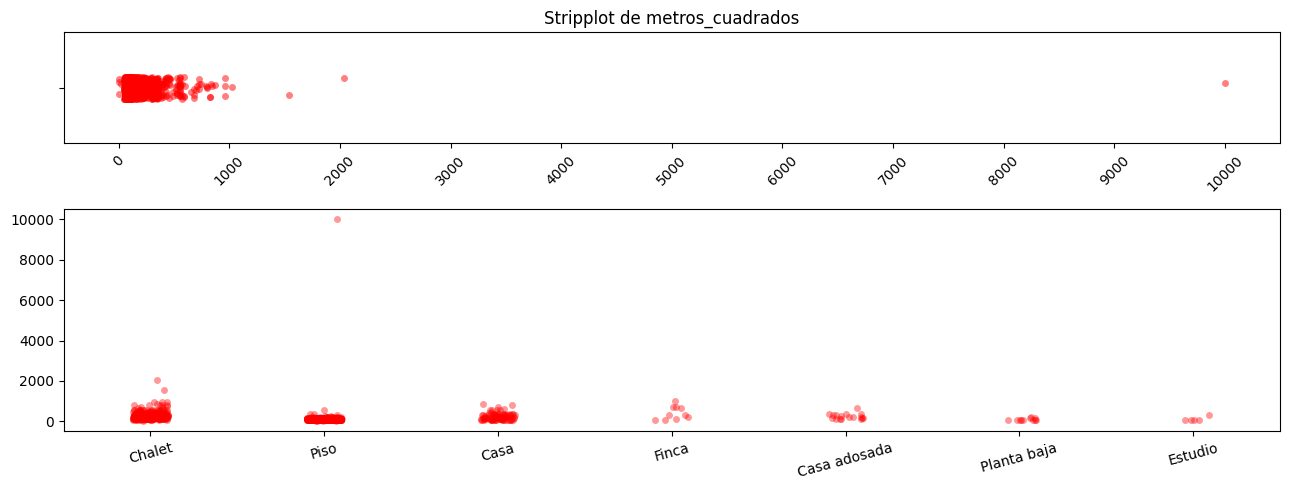

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Figura combinada con dos gráficos
fig, axes = plt.subplots(2, 1, figsize=(13, 5), gridspec_kw={'height_ratios': [1, 2]})

# Stripplot horizontal total de metros cuadrados
sns.stripplot(x=df['metros_cuadrados'], color='red', alpha=0.5, jitter=True, ax=axes[0])
axes[0].set_title("Stripplot de metros_cuadrados")
axes[0].set_xlabel("")  # Eliminar título del eje x
axes[0].set_ylabel("")  # Eliminar título del eje y

# Ajustar ticks del eje x para incluir más marcas
axes[0].set_xticks(np.arange(0, df['metros_cuadrados'].max() + 1000, step=1000))  # Marcas cada 1000
axes[0].tick_params(axis='x', rotation=45)

# Stripplot por tipo de vivienda
sns.stripplot(x='tipo_vivienda', y='metros_cuadrados', data=df, color='red', alpha=0.4, jitter=True, ax=axes[1])
axes[1].tick_params(axis='x', rotation=15)
axes[1].set_xlabel("")  # Eliminar título del eje x
axes[1].set_ylabel("")  # Eliminar título del eje y

# Ajustar diseño
plt.tight_layout()
plt.show()


In [29]:
df.loc[df["metros_cuadrados"] > 1000]

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
306,Manises,Piso,3.0,9999.0,NaN,NaN,"Vivienda en el municipio de Paterna, provincia...",[],No,90000.0,0
313,Manises,Chalet,5.0,2040.0,3.0,NaN,Sus tres cúpulas ubicadas en la zona alta y su...,"['Parking', 'Terraza']",No,1200000.0,0
320,Manises,Finca,6.0,1023.0,5.0,NaN,"¡Bienvenido a esta espectacular masía, donde l...","['Parking', 'Terraza']",No,690000.0,0
502,Manises,Chalet,7.0,1541.0,NaN,NaN,Masía con tres viviendas independientes en gra...,[],Sí,900000.0,0


### Podemos ver los **outliers a partir de los 1000 m2**, en especial el de 9999 m2, y esto **generará problemas** para el modelo, por lo que vamos a **eliminar** todas las filas que contengan un valor **superior a los 1000 m2**.

In [30]:
df = df[df['metros_cuadrados'] <= 1000]

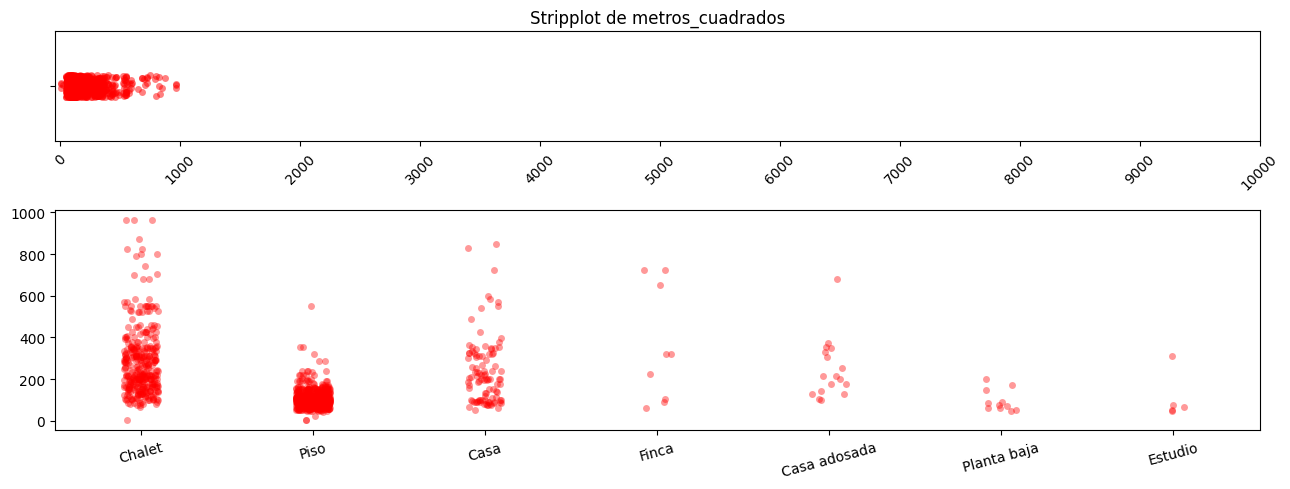

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Figura combinada con dos gráficos
fig, axes = plt.subplots(2, 1, figsize=(13, 5), gridspec_kw={'height_ratios': [1, 2]})

# Stripplot horizontal total de metros cuadrados
sns.stripplot(x=df['metros_cuadrados'], color='red', alpha=0.5, jitter=True, ax=axes[0])
axes[0].set_title("Stripplot de metros_cuadrados")
axes[0].set_xlabel("")  # Eliminar título del eje x
axes[0].set_ylabel("")  # Eliminar título del eje y

# Ajustar ticks del eje x para incluir más marcas
axes[0].set_xticks(np.arange(0, df['metros_cuadrados'].max() + 10000, step=1000))  # Marcas cada 1000
axes[0].tick_params(axis='x', rotation=45)

# Stripplot por tipo de vivienda
sns.stripplot(x='tipo_vivienda', y='metros_cuadrados', data=df, color='red', alpha=0.4, jitter=True, ax=axes[1])
axes[1].tick_params(axis='x', rotation=15)
axes[1].set_xlabel("")  # Eliminar título del eje x
axes[1].set_ylabel("")  # Eliminar título del eje y

# Ajustar diseño
plt.tight_layout()
plt.show()


In [32]:
df["metros_cuadrados"].value_counts().sort_index(ascending=False)

metros_cuadrados
961.0    3
870.0    1
847.0    1
831.0    1
825.0    2
        ..
46.0     1
44.0     1
43.0     1
21.0     1
1.0      3
Name: count, Length: 268, dtype: int64

### Continuamos ahora con la columna **"aseos"**.

In [33]:
print(df['aseos'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["aseos"].value_counts()

578


aseos
2.0     313
1.0     170
3.0      91
4.0      45
5.0       4
11.0      2
6.0       2
16.0      1
Name: count, dtype: int64

### Vamos a utilizar la columna **'Descripción'** para ver si podemos extraer información para **"aseos"**, ya que esta tiene muchos valores NaNs.

In [34]:
df['descripcion'].isna().sum() # Mostrará el num de NaNs existentes en la columna

np.int64(18)

In [35]:
import re

# Lista de palabras clave relacionadas con baños o aseos
palabras_clave = ["aseo", "aseos", "baño", "baños", "toilet"]

for index, row in df.iterrows():
    if pd.isna(row['aseos']):  # Si el valor en aseos es NaN
        descripcion = row['descripcion']

        # Si es una lista, concatenar los elementos que son strings
        if isinstance(descripcion, list):
            descripcion = " ".join([str(item).lower() for item in descripcion if isinstance(item, str)])
        # Si es un string directamente, convertirlo a minúsculas
        elif isinstance(descripcion, str):
            descripcion = descripcion.lower()
        else:
            descripcion = ""  # Si no es ni lista ni string, lo tratamos como vacío

        # Limpiar la descripción para eliminar ruido
        descripcion = re.sub(r'[^\w\s]', '', descripcion)  # Quitar puntuación

        # Verificar si alguna palabra clave está en la descripción
        if any(palabra in descripcion for palabra in palabras_clave):
            # print(f"Fila {index}: {descripcion}")

            # Buscar el número asociado a las palabras clave con hasta 4 palabras intermedias
            match = re.search(r'(\d+)\s*(?:\w+\s*){0,4}(' + "|".join(palabras_clave) + ')', descripcion)
            if match:
                numero_aseos = int(match.group(1))  # Extraer el número como entero
                print(f"Fila {index}: -------->>> Aseos o baños encontrados: {numero_aseos} ---> {match}")
                # Actualizar el valor de la columna 'aseos'
                df.at[index, 'aseos'] = numero_aseos
            else:
                # Si no hay número, buscar la palabra "baño" o "aseo" en singular
                if "baño" in descripcion or "aseo" in descripcion:
                    print(f"Fila {index}: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.")
                    df.at[index, 'aseos'] = 1


print("Valores NaN:", df['aseos'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["aseos"].value_counts()

Fila 212: -------->>> Aseos o baños encontrados: 3 ---> <re.Match object; span=(62, 82), match='3 dormitorios 2 baño'>
Fila 229: -------->>> Aseos o baños encontrados: 300 ---> <re.Match object; span=(22, 54), match='300 metros 4 habitaciones 1 baño'>
Fila 384: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 395: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 397: -------->>> Aseos o baños encontrados: 4 ---> <re.Match object; span=(102, 125), match='4 habitaciones dos baño'>
Fila 401: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 402: -------->>> Aseos o baños encontrados: 1 ---> <re.Match object; span=(177, 183), match='1 aseo'>
Fila 403: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 404: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 410: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 412: -------->>> 'Baño' o 'aseo' detectado sin número, asignando 1.
Fila 4

aseos
2.0      322
1.0      246
3.0      101
4.0       48
5.0        4
11.0       2
300.0      2
6.0        2
30.0       1
65.0       1
16.0       1
70.0       1
Name: count, dtype: int64

### Y para los valores descomunales como 65, 300, 30, 70 aseos... vamos a tratarlos ya que ha tenido que haber un error. Utilizaremos la misma operacion anterior pero afectando sólo a los valores de aseos mayores que 11. Adaptaremos el codigo tambien para que en la descripción busque números escritos.

In [36]:
import re

# Lista de palabras clave relacionadas con baños o aseos
palabras_clave = ["aseo", "aseos", "baño", "baños", "toilet"]

# Lista de palabras que indican área o metros cuadrados
palabras_area = ["m2", "metros", "cuadrados"]

# Mapeo de palabras numéricas a números
numero_palabras = {
    "uno": 1, "dos": 2, "tres": 3, "cuatro": 4, "cinco": 5,
    "seis": 6, "siete": 7, "ocho": 8, "nueve": 9, "diez": 10
}

for index, row in df.iterrows():
    if row['aseos'] > 11:  # Procesar valores desproporcionados
        descripcion = row['descripcion']

        # Si es una lista, concatenar los elementos que son strings
        if isinstance(descripcion, list):
            descripcion = " ".join([str(item).lower() for item in descripcion if isinstance(item, str)])
        elif isinstance(descripcion, str):
            descripcion = descripcion.lower()
        else:
            descripcion = ""

        # Limpiar la descripción para eliminar ruido
        descripcion = re.sub(r'[^\w\s]', '', descripcion)

        # Buscar todos los números en la descripción junto con palabras clave o palabras de área
        matches = re.finditer(r'(\d+|(?:' + "|".join(numero_palabras.keys()) + r'))\s*(?:\w+\s*){0,1}(' + "|".join(palabras_clave + palabras_area) + ')', descripcion)
        
        for match in matches:
            numero = match.group(1)
            palabra = match.group(2)
            
            # Ignorar números asociados con palabras de área
            if palabra in palabras_area:
                print(f"Fila {index}: Ignorando número {numero} asociado a área: {palabra}")
                continue
            
            # Si está asociado a palabras clave, procesarlo
            if palabra in palabras_clave:
                # Convertir el número si está en palabras
                if numero.isdigit():
                    numero_aseos = int(numero)
                else:
                    numero_aseos = numero_palabras.get(numero, 1)
                
                print(f"Fila {index}: -------->>> Valor desproporcionado ajustado a: {numero_aseos} ---> {match}")
                df.at[index, 'aseos'] = numero_aseos
                break  # Detenerse después de encontrar un número válido
        else:
            # Si no se encuentra un número válido
            print(f"Fila {index}: -------->>> Valor desproporcionado no ajustado, asignando 1.")
            df.at[index, 'aseos'] = 1


print(df['aseos'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["aseos"].value_counts()

Fila 229: Ignorando número 300 asociado a área: metros
Fila 229: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(48, 54), match='1 baño'>
Fila 615: Ignorando número 140 asociado a área: m2
Fila 615: Ignorando número 124 asociado a área: m2
Fila 615: Ignorando número 30 asociado a área: m2
Fila 615: -------->>> Valor desproporcionado ajustado a: 2 ---> <re.Match object; span=(224, 232), match='dos baño'>
Fila 912: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(104, 110), match='1 baño'>
Fila 947: Ignorando número 300 asociado a área: metros
Fila 947: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(48, 54), match='1 baño'>
Fila 1121: -------->>> Valor desproporcionado no ajustado, asignando 1.
Fila 1179: -------->>> Valor desproporcionado ajustado a: 1 ---> <re.Match object; span=(57, 63), match='1 baño'>
475


aseos
2.0     323
1.0     251
3.0     101
4.0      48
5.0       4
11.0      2
6.0       2
Name: count, dtype: int64

In [37]:
pd.set_option('display.max_colwidth', None) # Opcion para visualizar todo el ancho de la columna de df
# df[df["aseos"] == 11] # Se trata de una masia, por lo que tiene sentido que hayan 11 aseos.
# df.loc[df["aseos"]==30,["descripcion"]]
pd.reset_option('display.max_colwidth', None) # Opcion para visualizar todo el ancho de la columna de df

### Para los NaN que todavia tenemos, vamos a aplicarles **SimpleImputer** con la ***mediana*** de aseos **según el "tipo de vivienda"** al que pertenezca dicho valor de aseo no encontrado.

In [38]:
from sklearn.impute import SimpleImputer

# Crear un imputador que use la mediana
imputador = SimpleImputer(strategy="median")

# Iterar por cada grupo de tipo de vivienda e imputar los valores NaN
for tipo, group in df.groupby("tipo_vivienda"):
    # Filtrar las filas del grupo
    group_indices = group.index
    group_data = group[['aseos']]

    # Imputar los valores NaN en aseos dentro del grupo
    if group_data['aseos'].isna().any():
        # Calcular la mediana del grupo antes de imputar
        mediana = group_data['aseos'].median()

        # Truncar la mediana (redondear hacia abajo)
        mediana_truncada = int(np.floor(mediana))  # Convertir explícitamente a int

        # Mostrar información sobre el grupo y su mediana
        print(f"Tipo de vivienda: '{tipo}' | Mediana calculada: {mediana} | Truncada: {mediana_truncada}")

        # Imputar los valores NaN en aseos dentro del grupo
        imputados = imputador.fit_transform(group_data)
        
        # Convertir los valores imputados a enteros redondeados
        imputados = np.floor(imputados).astype(int)  # Redondear y convertir a enteros

        # Actualizar los valores imputados en el DataFrame original
        df.loc[group_indices, 'aseos'] = imputados
    else:
        pass

print(df['aseos'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["aseos"].value_counts()

Tipo de vivienda: 'Casa' | Mediana calculada: 2.0 | Truncada: 2
Tipo de vivienda: 'Casa adosada' | Mediana calculada: 2.0 | Truncada: 2
Tipo de vivienda: 'Chalet' | Mediana calculada: 2.0 | Truncada: 2
Tipo de vivienda: 'Estudio' | Mediana calculada: 1.5 | Truncada: 1
Tipo de vivienda: 'Finca' | Mediana calculada: 2.0 | Truncada: 2
Tipo de vivienda: 'Piso' | Mediana calculada: 2.0 | Truncada: 2
Tipo de vivienda: 'Planta baja' | Mediana calculada: 1.0 | Truncada: 1
0


aseos
2.0     794
1.0     255
3.0     101
4.0      48
5.0       4
11.0      2
6.0       2
Name: count, dtype: int64

### Haremos lo mismo para la columna **"planta"**,
### pero antes hay que limpiar los datos para tenerlos en ***float***

In [39]:
print("Valores NaN:", df['planta'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["planta"].value_counts()

Valores NaN: 747


planta
2ª planta                           35
1ª planta                           35
Planta 3ª exterior con ascensor     32
Planta 1ª exterior con ascensor     31
Planta 2ª exterior con ascensor     28
3ª Planta                           23
4ª planta                           21
1ª Planta                           20
2ª Planta                           19
Planta 4ª exterior con ascensor     18
3ª planta                           18
Planta 1ª exterior sin ascensor     17
4ª Planta                           14
Planta 4ª exterior sin ascensor     14
5ª Planta                           13
Planta 5ª exterior con ascensor     13
Planta 5ª exterior sin ascensor     11
5ª planta                           11
Planta 2ª exterior sin ascensor     11
Planta 3ª exterior sin ascensor      8
Planta 6ª exterior con ascensor      7
Planta 1ª sin ascensor               6
Planta 2ª sin ascensor               5
6ª planta                            5
7ª planta                            4
Planta 10ª exterio

### La siguiente función **extrae el valor numérico** de cada fila y lo asigna como nuevo valor

In [40]:
def extraer_numero_planta(texto):
    if isinstance(texto, str):
        match = re.search(r'(\d+)', texto)  # Busca el primer número
        if match:
            return int(match.group(1))  # Retornar el número como entero
    return None

df['planta'] = df['planta'].apply(extraer_numero_planta)

print("Valores NaN:", df['planta'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["planta"].value_counts()

Valores NaN: 747


planta
1.0     112
2.0      99
3.0      88
4.0      72
5.0      50
6.0      14
7.0       8
8.0       6
9.0       5
10.0      4
15.0      1
Name: count, dtype: int64

### Para los NaN de la columna, vamos a aplicarles nuevamente **SimpleImputer** con la ***mediana*** de planta **según el "tipo de vivienda"** al que pertenezca dicho valor de planta no encontrada. En éste caso hay que mencionar que para el tipo de vivienda como chalet, o finca la planta se considera 0 ya que es una unica vivienda a nivel de suelo.

In [41]:
df["tipo_vivienda"].value_counts()

tipo_vivienda
Piso            709
Chalet          354
Casa            101
Casa adosada     17
Planta baja      11
Finca             9
Estudio           5
Name: count, dtype: int64

In [42]:
imputador = SimpleImputer(strategy="median")

# Asegurar que los valores en 'planta' sean numéricos
df['planta'] = pd.to_numeric(df['planta'], errors='coerce')

# Iterar por cada grupo de tipo de vivienda e imputar los valores NaN
for tipo, group in df.groupby("tipo_vivienda"):
    # Filtrar las filas del grupo
    group_indices = group.index
    group_data = group[['planta']]

    # Imputar directamente "0" para tipos específicos
    if tipo in ["Finca", "Chalet", "Planta baja", "Casa adosada"]:
        print(f"Asignado a planta 0 por ser tipo '{tipo}'")
        df.loc[group_indices, 'planta'] = 0
    else:
        # Imputar los valores NaN para otros tipos de vivienda
        if group_data['planta'].isna().any():
            # Calcular la mediana del grupo antes de imputar
            mediana = group_data['planta'].median()

            # Verificar si la mediana es NaN
            if np.isnan(mediana):
                print(f"Tipo de vivienda: '{tipo}' tiene una mediana NaN. Se asignará planta 0 por defecto.")
                mediana_truncada = 0
            else:
                # Truncar la mediana (redondear hacia abajo)
                mediana_truncada = int(np.floor(mediana))  # Convertir explícitamente a int

            # Mostrar información sobre el grupo y su mediana
            print(f"Tipo de vivienda: '{tipo}' | Mediana calculada: {mediana} | Truncada: {mediana_truncada}")

            # Imputar los valores NaN en planta dentro del grupo
            imputados = imputador.fit_transform(group_data)

            # Convertir los valores imputados a enteros truncados
            imputados = np.floor(imputados).astype(int).ravel()  # Asegurar que sea un array 1D

            # Verificar el tamaño antes de asignar
            if len(imputados) != len(group_indices):
                print(f"Error: Tamaño de imputados ({len(imputados)}) no coincide con índices ({len(group_indices)})")
            else:
                # Actualizar los valores imputados en el DataFrame original
                df.loc[group_indices, 'planta'] = imputados


print("\nValores NaN en 'planta':", df['planta'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["planta"].value_counts()


Tipo de vivienda: 'Casa' | Mediana calculada: 4.0 | Truncada: 4
Asignado a planta 0 por ser tipo 'Casa adosada'
Asignado a planta 0 por ser tipo 'Chalet'
Tipo de vivienda: 'Estudio' | Mediana calculada: 2.0 | Truncada: 2
Asignado a planta 0 por ser tipo 'Finca'
Tipo de vivienda: 'Piso' | Mediana calculada: 3.0 | Truncada: 3
Asignado a planta 0 por ser tipo 'Planta baja'

Valores NaN en 'planta': 0


planta
0.0     391
3.0     342
4.0     172
1.0     112
2.0     101
5.0      50
6.0      14
7.0       8
8.0       6
9.0       5
10.0      4
15.0      1
Name: count, dtype: int64

In [43]:
df.loc[df["planta"] == 0, ["tipo_vivienda"]].value_counts() # Para comprobar que la planta 0 son las que mencionamos

tipo_vivienda
Chalet           354
Casa adosada      17
Planta baja       11
Finca              9
Name: count, dtype: int64

In [44]:
df.head(1)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,precio,zona_centro
0,Manises,Chalet,4.0,414.0,2.0,0.0,Espectacular CASA de pueblo con una ubicada PR...,[],No,230000.0,0


### Genial, continuamos con la columna **"etiquetas"**, (saltandonos la de **descripción** que sólo la queremos de machaca de la información)

In [45]:
df["etiquetas"].value_counts()

etiquetas
[]                                              539
['Piso']                                        220
['Parking', 'Terraza']                           68
['Casa']                                         59
['Chalet']                                       56
['Ascensor']                                     53
['Villa']                                        35
['Terraza']                                      20
['Balcón']                                       17
['Alquilada']                                    13
['Ascensor', 'Parking']                           9
['Terraza', 'Piscina']                            8
['Ascensor', 'Terraza']                           8
['Ascensor', 'Balcón']                            8
['Terraza', 'Balcón']                             6
['Aire acondicionado']                            6
['Terraza', 'Calefacción']                        6
['1 hab.', 'Ascensor']                            6
['Parking', 'Piscina']                            5
['

### Comprobamos el tipo de datos que son:

In [46]:
df["etiquetas"].apply(type).value_counts()

etiquetas
<class 'str'>    1206
Name: count, dtype: int64

### Vemos que son todo **str** aunque parecieran listas, asi que vamos a **eliminar los caracteres de "[" y "]"** con el método **.replace()**

In [47]:
# Aplicar replace a cada elemento de la columna
df["etiquetas"] = df["etiquetas"].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", "") if isinstance(x, str) else x)

# Alternativa para aplicar replace
# df["etiquetas"] = df["etiquetas"].str.replace("[", "", regex=False).str.replace("]", "", regex=False).str.replace("'", "", regex=False)

df["etiquetas"].value_counts()

etiquetas
                                        539
Piso                                    220
Parking, Terraza                         68
Casa                                     59
Chalet                                   56
Ascensor                                 53
Villa                                    35
Terraza                                  20
Balcón                                   17
Alquilada                                13
Ascensor, Parking                         9
Terraza, Piscina                          8
Ascensor, Terraza                         8
Ascensor, Balcón                          8
Terraza, Balcón                           6
Aire acondicionado                        6
Terraza, Calefacción                      6
1 hab., Ascensor                          6
Parking, Piscina                          5
Parking                                   4
Parking, Terraza, Piscina                 4
Bajos                                     4
Balcón, Calefacción   

### Una vez listos para tratar, especificamos las etiquetas que nos interesan y aplicamos ***get_dummies*** para convertir en columnas nuevas los valores que nos puedan ser relevantes.

In [48]:
etiquetas_interes = ['Reformado', 'Ascensor', 'Terraza', 'Piscina', 'Aire acondicionado']

# Filtrar la columna 'etiquetas' para que solo queden las de interés
df['etiquetas_interes'] = df['etiquetas'].apply(
    lambda x: [etiqueta for etiqueta in x.split(', ') if etiqueta in etiquetas_interes]
)

# Convertir la columna 'etiquetas_interes' en cadenas de texto separadas por comas
df['etiquetas_interes'] = df['etiquetas_interes'].apply(lambda x: ', '.join(x))

# Aplicar get_dummies
dummies = df['etiquetas_interes'].str.get_dummies(sep=', ')

# Renombrar las columnas de dummies a minúsculas
dummies.columns = [col.lower() for col in dummies.columns]

# Concatenar los dummies con el DataFrame original si lo deseas
df = pd.concat([df, dummies], axis=1)

# Modificar el nombre de la columna
df["aire_acondicionado"] = df.pop('aire acondicionado')

# Mover la columna 'precio' al final del DataFrame
precio_col = df.pop('precio')
df['precio'] = precio_col
df.head(2)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,descripcion,etiquetas,garaje,zona_centro,etiquetas_interes,ascensor,piscina,reformado,terraza,aire_acondicionado,precio
0,Manises,Chalet,4.0,414.0,2.0,0.0,Espectacular CASA de pueblo con una ubicada PR...,,No,0,,0,0,0,0,0,230000.0
1,Manises,Piso,2.0,53.0,1.0,3.0,Sin comisiones de agencia. Piso ubicado en la ...,,No,0,,0,0,0,0,0,60000.0


In [49]:
df[["aire_acondicionado", "ascensor", "piscina", "reformado", "terraza"]].isna().sum() # Mostrará el num de NaNs existentes en las columnas

aire_acondicionado    0
ascensor              0
piscina               0
reformado             0
terraza               0
dtype: int64

### Genial, una vez tenemos la etiquetas más relevantes desglosadas, ya podemos **eliminar las columnas de "descripción", "etiquetas" y "etiquetas_interes"**

In [50]:
df = df.drop(["descripcion", "etiquetas", "etiquetas_interes"], axis=1)

In [51]:
df.head(3)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,garaje,zona_centro,ascensor,piscina,reformado,terraza,aire_acondicionado,precio
0,Manises,Chalet,4.0,414.0,2.0,0.0,No,0,0,0,0,0,0,230000.0
1,Manises,Piso,2.0,53.0,1.0,3.0,No,0,0,0,0,0,0,60000.0
2,Manises,Piso,4.0,190.0,1.0,3.0,No,0,0,0,0,0,0,65000.0


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1206 entries, 0 to 1209
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           1206 non-null   object 
 1   tipo_vivienda       1206 non-null   object 
 2   habitaciones        1206 non-null   float64
 3   metros_cuadrados    1206 non-null   float64
 4   aseos               1206 non-null   float64
 5   planta              1206 non-null   float64
 6   garaje              1206 non-null   object 
 7   zona_centro         1206 non-null   int64  
 8   ascensor            1206 non-null   int64  
 9   piscina             1206 non-null   int64  
 10  reformado           1206 non-null   int64  
 11  terraza             1206 non-null   int64  
 12  aire_acondicionado  1206 non-null   int64  
 13  precio              1201 non-null   float64
dtypes: float64(5), int64(6), object(3)
memory usage: 173.6+ KB


### Los NaNs de la columna precio, que son pocos, los eliminamos directamente ya que en la descripción no se encuentra el precio y no podemos inventarnoslo ni darle una media o mediana de los otros.

In [53]:
df.dropna(subset=['precio'], inplace=True)
# Restablecer el índice
df = df.reset_index(drop=True)
df["precio"].isna().sum()

np.int64(0)

### **Para finalizar** debemos convertir las columnas "object" en numericas, ya sea int o float. Por lo que vamos a emplear la ***herramienta de codificación*** **LabelEncoder()**

In [54]:
categoricas = ['municipio', 'tipo_vivienda', 'garaje'] # Comprobamos que no tienen NaN antes de codificar

for col in categoricas:
    print(f"{col}:", df[col].isna().sum())

municipio: 0
tipo_vivienda: 0
garaje: 0


### **Importante guardar las codificaciones** para posteriormente utilizarlas de nuevo en las futuras predicciones.

In [55]:
import joblib
from sklearn.preprocessing import LabelEncoder

mapeos = {} # Dict para almacenar los mapeos
label_encoders = {}  # Para almacenar los encoders de cada columna

for col in categoricas:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    mapeos[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    label_encoders[col] = le  # Guarda el encoder para cada columna por si necesitas revertirlo

# Guardar los mapeos y los encoders
joblib.dump(mapeos, "mapeos.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("Mapeos y LabelEncoders guardados correctamente.\n")

for columna, mapeo in mapeos.items():
    print(f"{columna}: {mapeo}")
    print("\n")

Mapeos y LabelEncoders guardados correctamente.
municipio: {'Aldaia': np.int64(0), 'Manises': np.int64(1), 'Otro': np.int64(2), 'Paterna': np.int64(3), 'Quart de Poblet': np.int64(4), 'Riba-Roja de Túria': np.int64(5)}


tipo_vivienda: {'Casa': np.int64(0), 'Casa adosada': np.int64(1), 'Chalet': np.int64(2), 'Estudio': np.int64(3), 'Finca': np.int64(4), 'Piso': np.int64(5), 'Planta baja': np.int64(6)}


garaje: {'No': np.int64(0), 'Sí': np.int64(1)}




In [56]:
df.head(3)

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,garaje,zona_centro,ascensor,piscina,reformado,terraza,aire_acondicionado,precio
0,1,2,4.0,414.0,2.0,0.0,0,0,0,0,0,0,0,230000.0
1,1,5,2.0,53.0,1.0,3.0,0,0,0,0,0,0,0,60000.0
2,1,5,4.0,190.0,1.0,3.0,0,0,0,0,0,0,0,65000.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           1201 non-null   int64  
 1   tipo_vivienda       1201 non-null   int64  
 2   habitaciones        1201 non-null   float64
 3   metros_cuadrados    1201 non-null   float64
 4   aseos               1201 non-null   float64
 5   planta              1201 non-null   float64
 6   garaje              1201 non-null   int64  
 7   zona_centro         1201 non-null   int64  
 8   ascensor            1201 non-null   int64  
 9   piscina             1201 non-null   int64  
 10  reformado           1201 non-null   int64  
 11  terraza             1201 non-null   int64  
 12  aire_acondicionado  1201 non-null   int64  
 13  precio              1201 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 131.5 KB


### LISTO! Ahora comprobamos que no tenemos ***valores repetidos*** y ***exportamos a un CSV*** para comenzar con el **entrenamiento el modelo!**

In [58]:
print(f"Antes de eliminar duplicados: {df.shape}")

# Nos basamos en las features más importantes de la vivienda para comprobar duplicados:
df = df.drop_duplicates(subset=['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados', 'aseos', 'planta', 'zona_centro', 'precio'])

print(f"Después de eliminar duplicados: {df.shape}")

Antes de eliminar duplicados: (1201, 14)
Después de eliminar duplicados: (1113, 14)


In [59]:
df.to_csv("../data/definitivo.csv", index=0)

#### Los entrenamientos se realizan por separado en diferentes Notebooks, con nombre **'modelo'.ipynb**

## Importante echar un vistazo a la **relación** resultante que tiene **cada feature respecto al target**, para hacernos una idea de lo que nos ha quedado y con lo que vamos a entrenar. (posiblemente hayan cambios según las necesidades)

In [ ]:
# Crear una figura con subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes = axes.flatten()

# Paleta de colores
colors = ["#FF9999", "#66B3FF", "#99FF99", "#FFCC99", "#C1C1C1",
          "#FF6666", "#85C1E9", "#F7DC6F", "#D2B4DE", "#76D7C4"]

# Relación entre metros_cuadrados y precio
sns.scatterplot(x=df['metros_cuadrados'], y=df['precio'], ax=axes[0], color=colors[0])
axes[0].set_title("Precio x Metros Cuadrados")
axes[0].set_xlabel("Metros Cuadrados")
axes[0].set_ylabel("Precio")

# Boxplot para aseos
sns.boxplot(x=df['aseos'], y=df['precio'], ax=axes[1], color=colors[1])
axes[1].set_title("Precio x num de Aseos")
axes[1].set_ylabel("Precio")

# Boxplot para municipio
sns.boxplot(x=df['municipio'], y=df['precio'], ax=axes[2], color=colors[2])
axes[2].set_title("Precio x Municipio")
axes[2].set_xlabel("Aldaia=0, Manises=1, Otros=2, Paterna=3, QuartdePoblet=4, Riba-Roja=5")
axes[2].set_ylabel("Precio")

# Boxplot para zona_centro
sns.boxplot(x=df['zona_centro'], y=df['precio'], ax=axes[3], color=colors[3])
axes[3].set_title("Precio x Zona Centro")
axes[3].set_xlabel("Zona Centro (0=No, 1=Sí)")
axes[3].set_ylabel("Precio")

# Boxplot para planta
sns.boxplot(x=df['planta'], y=df['precio'], ax=axes[4], color=colors[4])
axes[4].set_title("Precio x Planta")
axes[4].set_xlabel("Planta")
axes[4].set_ylabel("Precio")

# Boxplot para habitaciones
sns.boxplot(x=df['habitaciones'], y=df['precio'], ax=axes[5], color=colors[5])
axes[5].set_title("Precio x Habitaciones")
axes[5].set_xlabel("Habitaciones")
axes[5].set_ylabel("Precio")

# Boxplot para terraza
sns.boxplot(x=df['terraza'], y=df['precio'], ax=axes[6], color=colors[6])
axes[6].set_title("Precio x Terraza")
axes[6].set_xlabel("Terraza (0=No, 1=Sí)")
axes[6].set_ylabel("Precio")

# Boxplot para tipo vivienda
sns.boxplot(x=df['tipo_vivienda'], y=df['precio'], ax=axes[7], color=colors[7])
axes[7].set_title("Precio x Tipo Vivienda")
axes[7].set_xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
axes[7].set_ylabel("Precio")

# Boxplot para Garaje
sns.boxplot(x=df['garaje'], y=df['precio'], ax=axes[8], color=colors[8])
axes[8].set_title("Precio x Garaje")
axes[8].set_xlabel("Garaje (0=No, 1=Sí)")
axes[8].set_ylabel("Precio")

# Boxplot para aire acondicionado
sns.boxplot(x=df['aire_acondicionado'], y=df['precio'], ax=axes[9], color=colors[9])
axes[9].set_title("Precio x Aire Acondicionado")
axes[9].set_xlabel("Aire Acondicionado (0=No, 1=Sí)")
axes[9].set_ylabel("Precio")

# Ajustar diseño
plt.tight_layout()
plt.show()
